### Keras Deep Convolution GAN으로 손글씨 모방

#### 1. import packages & set parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from time import time

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, \
                         Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [2]:
# parameters
MY_EPOCH = 1000 #10000
MY_BATCH = 500
MY_NOISE = 100 # 생성자가 사용하는 노이즈 벡터
MY_SHAPE = (28, 28, 1)
MY_DROP = 0.4
MY_ALPHA = 0.01 # LeakyReLU의 alpha값 (입력이 음수로 들어올 때 새는정도)
TRAIN_MODE = 1

In [3]:
# 출력 이미지 폴더 생성
MY_FOLDER = 'output/'
os.makedirs(MY_FOLDER, exist_ok=True) # 존재해도 괜찮음

# 폴더 안에 기존 파일 지우기
# os.dir이나 os.listdir과 다르게 와일드카드 지원이 되는게 glob
for f in glob.glob(MY_FOLDER + "*"):
    os.remove(f)

#### 2. load dataset & data preprocessing

In [4]:
def read_data():
    # MNIST 학습용 입력 데이터셋
    (X_train, _), (_, _) = mnist.load_data()

    # 샘플 확인
    #print(X_train[0])
    plt.imshow(X_train[0], cmap='gray')

    # 화소 데이터 -1 ~ 1  스케일링
    # 225 / 2 = 127.5로 나누고 1.0을 빼면 됨
    X_train = X_train / 127.5 - 1.0

    # 진짜 데이터 차원 늘리기
    # 60000, 28, 28 -> 60000, 28, 28, 1
    # X_train = np.expand_dims(X_train, axis=1) # 1개의 축 더 추가
    print(X_train.shape)
    X_train = X_train.reshape(60000, 28, 28, 1)
    
    return X_train

#### 3. Model creating

In [5]:
# 생성자 구현
def build_generator():
    model = Sequential()

    # 입력층과 블럭 2
    model.add(Dense(units=7*7*64,
                    input_dim=MY_NOISE)) # 3136(=7*7*64)
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 블럭 3
    model.add(Reshape((7, 7, 64))) # 7, 7, 64
    model.add(Dropout(MY_DROP))

    # 블럭 4
    model.add(UpSampling2D(size=2)) # 14, 14, 64
    model.add(Conv2DTranspose(filters=64,
                              kernel_size=5,
                              strides=1,
                              padding='same')) # 14, 14, 64
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 블럭 5
    model.add(UpSampling2D(size=2)) # 28, 28, 64
    model.add(Conv2DTranspose(filters=64,
                              kernel_size=5,
                              strides=1,
                              padding='same')) # 28, 28, 64
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 블럭 6
    model.add(Conv2DTranspose(filters=64,
                              kernel_size=5,
                              strides=1,
                              padding='same')) # 28, 28, 64
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 블럭 7
    model.add(Conv2DTranspose(filters=1,
                              kernel_size=5,
                              strides=1,
                              padding='same',
                              activation='tanh')) # 28, 28, 1


    #print('생성자 요약')
    #model.summary()

    return model



In [6]:
# 감별자 구현
def build_discriminator():
    model = Sequential()

    # 입력층과 블럭 2
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=2,
                     input_shape=MY_SHAPE,
                     padding='same')) # 14, 14, 64 (strides=2 -> division by 2)
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))

    # 블럭 3
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=2,
                     input_shape=MY_SHAPE,
                     padding='same')) # 7, 7, 64
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))    

    # 블럭 4
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=2,
                     input_shape=MY_SHAPE,
                     padding='same'))  # 4, 4, 64
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))  

    # 블럭 5
    model.add(Conv2D(filters=64,
                     kernel_size=5,
                     strides=1,
                     input_shape=MY_SHAPE,
                     padding='same')) # 4, 4, 64
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))  

    # 블럭 6
    model.add(Flatten())

    # 블럭 7
    model.add(Dense(units=1,
                    activation='sigmoid'))

    #print('감별자 요약')
    #model.summary()

    return model


In [7]:
# DC-GAN 구현
def build_GAN():
    model = Sequential()

    # 생성자 만들기
    generator = build_generator()

    # 감별자 만들기
    discriminator = build_discriminator()
    discriminator.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['acc'])
    
    discriminator.trainable = False # 생성자 학습 시 감별자는 가중치가 고정되어야 함
                                    # (학습하지 않아야 함)

    # GAN 만들기
    model.add(generator)
    model.add(discriminator)

    # 생성자 학습용 최적화/손실 함수
    # (판별자는 학습 안됨! trainable = False)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy')
    
    #print('GAN 요약')
    #model.summary()

    return generator, discriminator, model


#### 4. Model Learning

In [8]:
# 생성자 학습
def train_generator():
    # 가짜 이미지 한 batch 만들기
    # 균일 분포 사용
    noise = np.random.uniform(-1, 1, (MY_BATCH, MY_NOISE)) # 500*100 (배치크기*노이즈수)
    #print(noise.shape)
    all_1 = np.ones((MY_BATCH, 1)) # 1을 가득 채운 행렬 (판별자가 1(참)이라고 말하는 걸 원함!)

    # 감별자 속이기 훈련
    g_loss = gan.train_on_batch(noise, all_1)
    #print("Generator Loss:", g_loss)
    return g_loss


In [9]:
# 감별자 학습
def train_discriminator():
    # 진짜 이미지 한 batch로 학습 (500개)
    total = X_train.shape[0]
    pick = np.random.randint(0, total, MY_BATCH)  # 0 ~ total 사이에서 MY_BATCH개 난수

    # 진짜 이미지 500개
    real = X_train[pick]
    all_1 = np.ones((MY_BATCH, 1)) # 진짜 이미지니까 1로 채워야 함
    d_loss_real = discriminator.train_on_batch(real, all_1)
    #print("Discriminator Real Loss", d_loss_real)

    # 가짜 이미지 한 batch로 학습
    noise = np.random.uniform(-1, 1, (MY_BATCH, MY_NOISE)) # -1 ~ 1(표준균일분포) 사이의 실수 생성
    fake = generator.predict(noise)
    #print('Fake:', fake)
    all_0 = np.zeros((MY_BATCH, 1)) # 가짜 이미지니까 0으로 해야 함
    d_loss_fake = discriminator.train_on_batch(fake, all_0)
    #print("Discriminator Fake Loss:", d_loss_fake)

    d_loss = np.add(d_loss_real, d_loss_fake) / 2
    #print("Total Discriminator Loss:", d_loss)

    return d_loss


In [10]:
# 샘플 이미지 출력
def sample(epoch):
    # 생성자가 사용할 noise
    noise = np.random.uniform(-1, 1, (16, MY_NOISE))
    fake = generator.predict(noise)
    #fake = 0.5 * fake + 0.5 # -1 ~ 1 -> 0 ~ 1
    print(fake.shape)
    fake = np.squeeze(fake)
    print(fake.shape)

    '''
    # fake 이미지를 Canvas로 이동
    row = col = 4
    _, canvas = plt.subplots(row, col)

    cnt = 0
    for i in range(row):
      for j in range(col):
        canvas[i, j].imshow(fake[cnt], cmap='gray')
        canvas[i, j].axis('off')
        cnt += 1
    
    path = os.path.join(MY_FOLDER, 'img-{}'.format(epoch))
    plt.savefig(path)
    plt.close()
    '''
    # 캔버스 만들기
    file, canvas = plt.subplots(4,4,figsize=(5,5))

    # fake에 이미지들을 캔버스로 이동
    cnt = 0
    for i in range(4):
      for j in range(4):
        canvas[i,j].imshow(fake[cnt],cmap='gray')
        canvas[i,j].axis('off')
        cnt += 1

    plt.show()    

In [11]:
def train_GAN(): # GAN 학습
  begin = time()

  for epoch in range(MY_EPOCH):
    d_loss = train_discriminator()
    for i in range(1):
      g_loss = train_generator()
  
    # 매 100번 epoch 마다 손실 출력 + 이미지 생성
    if epoch % 100 == 0:
      print("Epoch:", epoch)
      print('Generator Loss: {:.2f}'.format(g_loss))
      print('Discriminator Loss: {:.2f}'.format(d_loss[0]))
      sample(epoch)
  
  end = time()
  print('Learning time: {:.2f}sec'.format(end - begin))

#### 5. Main function (Control tower)

(60000, 28, 28)
Epoch: 0
Generator Loss: 0.55
Discriminator Loss: 0.72
(16, 28, 28, 1)
(16, 28, 28)


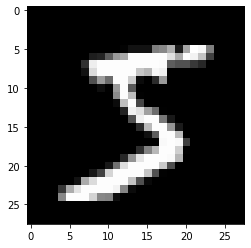

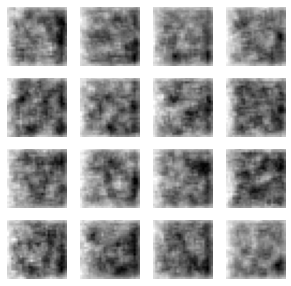

Epoch: 100
Generator Loss: 0.23
Discriminator Loss: 0.27
(16, 28, 28, 1)
(16, 28, 28)


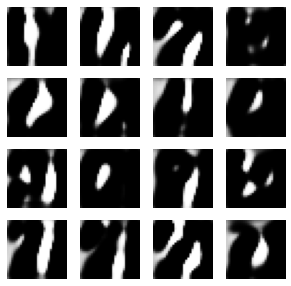

Epoch: 200
Generator Loss: 0.01
Discriminator Loss: 0.03
(16, 28, 28, 1)
(16, 28, 28)


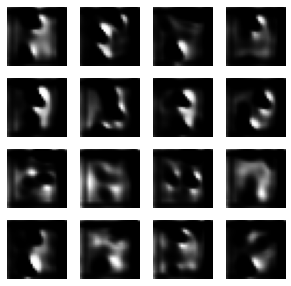

Epoch: 300
Generator Loss: 1.93
Discriminator Loss: 0.25
(16, 28, 28, 1)
(16, 28, 28)


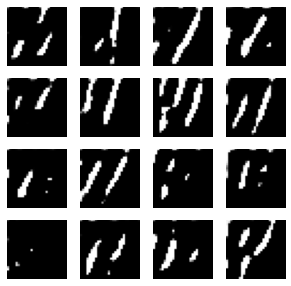

Epoch: 400
Generator Loss: 3.64
Discriminator Loss: 0.17
(16, 28, 28, 1)
(16, 28, 28)


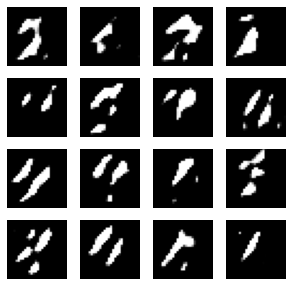

Epoch: 500
Generator Loss: 4.72
Discriminator Loss: 0.10
(16, 28, 28, 1)
(16, 28, 28)


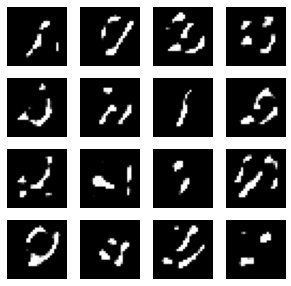

Epoch: 600
Generator Loss: 1.61
Discriminator Loss: 0.29
(16, 28, 28, 1)
(16, 28, 28)


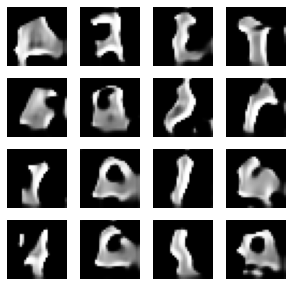

Epoch: 700
Generator Loss: 1.95
Discriminator Loss: 0.31
(16, 28, 28, 1)
(16, 28, 28)


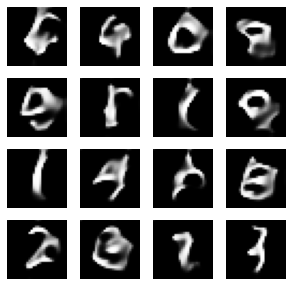

Epoch: 800
Generator Loss: 1.59
Discriminator Loss: 0.48
(16, 28, 28, 1)
(16, 28, 28)


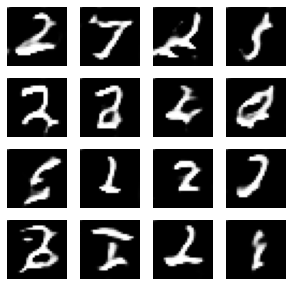

Epoch: 900
Generator Loss: 1.39
Discriminator Loss: 0.37
(16, 28, 28, 1)
(16, 28, 28)


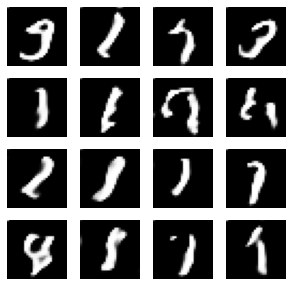

Learning time: 147.03sec


In [12]:
# 데이터 처리
X_train = read_data()

# GAN 만들기
generator, discriminator, gan = build_GAN()

# 지금 만드는 함수
# sample(0)
train_GAN()